In [2]:
"""
a demo of LR-based Avazu-CTR prediction.
    
    1.apply one-hot transform to dataset.
    2.using SGDClassifier for the training of Logistic Regression.
    3.predicting to generate submission.
    
"""

##==================== Package ====================##
import pandas as pd
import numpy as np
from dummyPy import OneHotEncoder  # for one-hot encoding on a large scale of chunks
from sklearn.linear_model import SGDClassifier  # using SGDClassifier for training incrementally
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt 
import pickle


In [5]:
##==================== File-Path (fp) ====================##
## data after selecting features (LR_fun needed)
## and setting rare categories' value to 'other' (feature filtering)
fp_train_f = "../../Datasets/ctr/train_f.csv"
fp_test_f  = "../../Datasets/ctr/test_f.csv"

## one-hot encoder
fp_oh_enc = "../../Datasets/ctr/oh_enc"

## lr-model
fp_lr_model = "../../Datasets/ctr/lr/lr_model"

## submission files
fp_sub = "../../Datasets/ctr/lr/LR_submission.csv"


In [6]:
##==================== LR training ====================##
oh_enc = pickle.load(open(fp_oh_enc, 'rb'))

df_train_f = pd.read_csv(fp_train_f, dtype={'id':str},
                         index_col=None,
                         chunksize=10000, iterator=True)

lr_model = SGDClassifier(loss='log')  # using log-loss for LogisticRegression
scores = []


In [9]:
k = 1  # using k and i to control the training scale (training_samples used = (all_samples / k)
i = 1
for chunk in df_train_f:
    if i < k: 
        i += 1
        continue
    i = 1
    df_train = oh_enc.transform(chunk)
    #----- training LR -----#
    feature_train = df_train.columns.drop(['id', 'click'])
    train_X = df_train[feature_train]
    train_y = df_train['click'].astype('int')
    lr_model.partial_fit(train_X, train_y, classes = [0,1])  # fitting
    
    # the score of training
    y_pred = lr_model.predict_proba(train_X)[:, 1]
    score = log_loss(train_y, y_pred)
    scores.append(score)

## store the pre-trained lr_model
pickle.dump(lr_model, open(fp_lr_model, 'wb'))


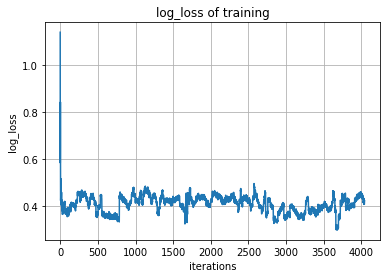

In [10]:
## show the training curve
f1 = plt.figure(1)
plt.plot(scores)
plt.xlabel('iterations')
plt.ylabel('log_loss')
plt.title('log_loss of training')
plt.grid()
plt.show()


In [11]:
##==================== prediction and generation of submissions ====================##
df_test_f = pd.read_csv(fp_test_f, 
                        dtype={'id':str}, 
                        index_col=None,
                        chunksize=50000, iterator=True)        

lr_model = pickle.load(open(fp_lr_model, 'rb'))

hd = True
for chunk in df_test_f:
    df_test = oh_enc.transform(chunk)
    #----- predict -----#
    feature_test = df_test.columns.drop(['id'])
    test_X = df_test[feature_test]
    y_pred = lr_model.predict_proba(test_X)[:, 1]  # get the probability of class 1
    #----- generation of submission -----#
    chunk['click'] = y_pred
    with open(fp_sub, 'a') as f: 
        chunk.to_csv(f, columns=['id', 'click'], header=hd, index=False) 
    hd = False

print(' - PY131 - ')

 - PY131 - 
